# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

### Описание полей данных

- `BeginDate` – дата начала пользования услугами.
- `EndDate` – дата окончания пользования услугами.
- `Type` – тип оплаты: ежемесячный, годовой и тд.
- `PaperlessBilling` – безналичный расчет.
- `PaymentMethod` – способ оплаты.
- `MonthlyCharges` – ежемесячные траты на услуги.
- `TotalCharges` – всего потрачено денег на услуги.
- `Dependents` – наличие иждивенцев.
- `Senior Citizen` – наличие пенсионного статуса по возрасту.
- `Partner` – наличие супруга(и).
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.


Во всех файлах столбец `customerID` содержит код клиента.


Информация о договорах актуальна на 1 февраля 2020.

### План по работе

1. Загрузить и предварительно изучить полученные данные. 
2. Провести предобработку и исследовательский анализ данных. Выделить целевой признак. Объединить данные в одну таблицу.
3. Подготовка данных для модели. 
4. Разделить итоговую таблицу на обучающую, тренировочную и тестовую выборки (при делении на выборки соотношение тренировочной к тестовой должно быть 3/1). 
5. Выбрать модели машинного обочения, подходящие для проведения исследования данных, провести подбор гиперпараметров и обучить модели (минимальный порог AUC-ROC=0.85).
6. Сравнить модели и оценить эффективность лучшей на тестовой выборке. 
7. Сделать выводы.

### Цель проекта

Найти модель машинного обучения которая будет находить клиетов, которые планируют отказаться от услуг компании. 

## Загрузка и предварительный анализ данных

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, make_scorer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 220523

Загрузим данные.

In [2]:
df_contract = pd.read_csv('/Users/alexander/Documents/Python/Отток клиентоа телекомуникационной компании/contract_new.csv') 
df_internet = pd.read_csv('/Users/alexander/Documents/Python/Отток клиентоа телекомуникационной компании/internet_new.csv')
df_personal = pd.read_csv('/Users/alexander/Documents/Python/Отток клиентоа телекомуникационной компании/personal_new.csv') 
df_phone = pd.read_csv('/Users/alexander/Documents/Python/Отток клиентоа телекомуникационной компании/phone_new.csv') 

In [3]:
df_contract.info()
display(df_contract.head(15))
print('Число дубликатов:', df_contract.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


Число дубликатов: 0


В таболице `df_contract` пропусков и дубликатов нет, поля `BeginDate`, `EndDate` и `TotalCharges` имеют неверный тип данных. Всего в компании зарегистрировано 7043 клиента.

In [4]:
df_internet.info()
display(df_internet.head(15))
print('Число дубликатов:', df_internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


Число дубликатов: 0


В таболице `df_internet` пропусков и дубликатов нет, но смаих клиентов меньше чем в таблице `df_contract`, вероятно клиенты попадают в эту таблицу, если хотя бы 1 раз воспользовались 1 из этих услуг, потому при объединении таблоиц для клиентов которых нет в таблице `df_contract`, будет стоять значени `No`.

In [5]:
df_personal.info()
display(df_personal.head(15))
print('Число дубликатов:', df_personal.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Число дубликатов: 0


В таболице `df_personal` пропусков и дубликатов нет, количество клиентов совпадает с таблицей `df_contract`.

In [6]:
df_phone.info()
display(df_phone.head(15))
print('Число дубликатов:', df_phone.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Число дубликатов: 0


В таболице `df_phone` пропусков и дубликатов нет, количество клиентов меньше чем в таблице `df_contract`. Верорятно из-за того же принципа по которому клиенты не попадают в таблицу `df_internet`, у клиетов которых нет в этой таблице никогда не было многоканального телефона.

### Вывод по предворительному исследованию

- Из таблицы `contract_new.csv` (информация о договоре) выяснилось что в базе компании 7043 клиента, включая тех что перестали пользоваться услугами компании.
- В таблице `personal_new.csv` (персональные данные клиента) тоже самое число клиентов.
- В таблицах `internet_new.csv` (информация об интернет-услугах) и `phone_new.csv` (информация об услугах телефонии) клиентов меньше, ввиду того что они не пользовались теми или иными услугами, потому после объединения всех таблиц пропуски будут заполнены в стоовествии с условием 'No' (0).
- Пропусков и дубликатов во всех таблицах не обнаружено.
- В таболице `df_contract` поля `BeginDate`, `EndDate` и `TotalCharges` имеют неверный тип данных.
- Целевой признак необходимо будет создать и заполнить '1' для тех клиентов, у кого стоит дата в поле `EndDate` таблицы `contract_new.csv`.
- Используя поля `BeginDate` и `EndDate` можно добавить поле 'срок прибывания в компании' (для тех у кого поле незаполнено использовать дату из условия 1 февраля 2020). 

## Предобработка и исследовательский анализ данных

Изменим типы данных в таболице `df_contract` для полей `BeginDate`, `EndDate` и `TotalCharges`

In [7]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
#предварительно заменим 'No' на дату из условия 1 февраля 2020
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')
df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype('int') #меняю тип данных для удобства в работе

Во время преобразования поля `TotalCharges` в 'int' вышла ошибка: `could not convert string to float: ' '`, посмотрим что это за данные.

In [8]:
df_contract.loc[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73,


Исходя из поля `EndDate` - это пользователи которые зарегистрировались в дату выгрузки и данные по ним вероятно поступят на следующий день. Полей всего 21, заменим пропуски на 0.

In [9]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace([' '], 0)
#чтобы не было ошибки сначала переведем в 'float' потом в 'int'
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float').astype('int')

In [10]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   int64         
 7   TotalCharges      7043 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 440.3+ KB


Все поля прелбразованы в нужный тип данных. Теперь можно объединить таблице по ключевому полю `customerID`.

In [11]:
df = df_contract.set_index('customerID').join(df_phone.set_index('customerID'))
df = df.join(df_personal.set_index('customerID'))
df = df.join(df_internet.set_index('customerID'))

df.head(15)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29,31,NaN,Female,0,Yes,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56,2071,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53,226,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42,1960,NaN,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70,353,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99,1150,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89,2058,Yes,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29,300,NaN,Female,0,No,No,DSL,Yes,No,No,No,No,No
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104,3573,Yes,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes


Таблицы объеденены. Заменим пропуски на 'No'.

In [12]:
df.fillna('No', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int64         
 6   TotalCharges      7043 non-null   int64         
 7   MultipleLines     7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

Изучим значения уникальные значения полей типа 'object'.

In [13]:
def unique_values(df):
    for column in df.columns:
        print('Уникальные значения столбца:', column)
        #print(df[column].unique())
        print(df[column].value_counts())
        print()

In [14]:
unique_values(df.drop(['BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges'], axis=1))

Уникальные значения столбца: Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Уникальные значения столбца: PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Уникальные значения столбца: PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Уникальные значения столбца: MultipleLines
No     4072
Yes    2971
Name: MultipleLines, dtype: int64

Уникальные значения столбца: gender
Male      3555
Female    3488
Name: gender, dtype: int64

Уникальные значения столбца: SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Уникальные значения столбца: Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Уникальные значения столбца: Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64

Уникальные значения столбца: InternetService
Fiber optic    3096
DSL 

- Большинство данных бинарны, заполним 'Yes' и 'No', на 1 и 0 соотвественно.
- Поле `gender` преобразуем в поле `male`, где значение '1' будет у мужчин
- Поля `Type`, `PaymentMethod` и `InternetService` преобразуем методом OHE для моделей логистической регрессии и случайного леса, а для LGBM переведем в категории в момент деления на выборки.

In [15]:
binary_list= ['PaperlessBilling',
                'MultipleLines',
                'OnlineSecurity',
                'OnlineBackup',
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'StreamingMovies', 
                'Partner', 
                'Dependents']

In [16]:
def encode_for_binary(df):
    for column in binary_list:
        df[column] = np.where(df[column] != 'Yes', 1, 0)

encode_for_binary(df)

df['male'] = np.where(df['gender'] != 'Male', 1, 0)
# избавимся от преобразованного столбца
df = df.drop(['gender'], axis=1)


df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,male
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,0,Electronic check,29,31,1,0,0,1,DSL,1,0,1,1,1,1,1
5575-GNVDE,2017-04-01,2020-02-01,One year,1,Mailed check,56,2071,1,0,1,1,DSL,0,1,0,1,1,1,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,0,Mailed check,53,226,1,0,1,1,DSL,0,0,1,1,1,1,0
7795-CFOCW,2016-05-01,2020-02-01,One year,1,Bank transfer (automatic),42,1960,1,0,1,1,DSL,0,1,0,0,1,1,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,0,Electronic check,70,353,1,0,1,1,Fiber optic,1,1,1,1,1,1,1


Введеем новую переменную - количество дней, которые клиент является/являлся клиентом компании.

In [17]:
df['days'] = (df['EndDate'] - df['BeginDate']).dt.days
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,male,days
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,0,Electronic check,29,31,1,0,0,1,DSL,1,0,1,1,1,1,1,31
5575-GNVDE,2017-04-01,2020-02-01,One year,1,Mailed check,56,2071,1,0,1,1,DSL,0,1,0,1,1,1,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,0,Mailed check,53,226,1,0,1,1,DSL,0,0,1,1,1,1,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,1,Bank transfer (automatic),42,1960,1,0,1,1,DSL,0,1,0,0,1,1,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,0,Electronic check,70,353,1,0,1,1,Fiber optic,1,1,1,1,1,1,1,153


Выделим целевой признак.

In [18]:
df['resigned'] = np.where(df['EndDate'] != '2020-02-01', 1, 0)

df.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,male,days,resigned
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,0,Electronic check,29,31,1,0,0,...,DSL,1,0,1,1,1,1,1,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,1,Mailed check,56,2071,1,0,1,...,DSL,0,1,0,1,1,1,0,1036,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,0,Mailed check,53,226,1,0,1,...,DSL,0,0,1,1,1,1,0,123,0
7795-CFOCW,2016-05-01,2020-02-01,One year,1,Bank transfer (automatic),42,1960,1,0,1,...,DSL,0,1,0,0,1,1,0,1371,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,0,Electronic check,70,353,1,0,1,...,Fiber optic,1,1,1,1,1,1,1,153,0
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,0,Electronic check,99,1150,0,0,1,...,Fiber optic,1,1,0,1,0,0,1,337,0
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,0,Credit card (automatic),89,2058,0,0,1,...,Fiber optic,1,0,1,1,0,1,0,671,0
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,1,Mailed check,29,300,1,0,1,...,DSL,0,1,1,1,1,1,1,306,0
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,0,Electronic check,104,3573,0,0,0,...,Fiber optic,1,1,0,0,0,0,1,945,0


Признак добавлен.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int64         
 6   TotalCharges      7043 non-null   int64         
 7   MultipleLines     7043 non-null   int64         
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   int64         
 13  OnlineBackup      7043 non-null   int64         
 14  DeviceProtecti

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PaperlessBilling,7043.0,0.407781,0.491457,0.0,0.0,0.0,1.0,1.0
MonthlyCharges,7043.0,64.295897,30.092727,18.0,35.0,70.0,89.0,118.0
TotalCharges,7043.0,2114.859009,2112.745015,0.0,436.5,1343.0,3236.0,9221.0
MultipleLines,7043.0,0.578163,0.493888,0.0,0.0,1.0,1.0,1.0
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043.0,0.516967,0.499748,0.0,0.0,1.0,1.0,1.0
Dependents,7043.0,0.700412,0.458110,0.0,0.0,1.0,1.0,1.0
OnlineSecurity,7043.0,0.713332,0.452237,0.0,0.0,1.0,1.0,1.0
OnlineBackup,7043.0,0.655119,0.475363,0.0,0.0,1.0,1.0,1.0
DeviceProtection,7043.0,0.656112,0.475038,0.0,0.0,1.0,1.0,1.0


- Безналичный расчет использует 40% клиентов
- Несколько линий почти 60%
- Пенсионеров около 16%, женатых 51%, соотношение мужчин и женщин почти равное, много зависимых порядка 70% 
- Онлайн услугами пользуется боле 65%

Рассмотрим ряд признаков на графике.

In [21]:
# выставим размер графиков
plt.rcParams["figure.figsize"] = (20,8)
# темный фон с сеткой в seaborn
sns.set_style("darkgrid")

count    7043.000000
mean       64.295897
std        30.092727
min        18.000000
25%        35.000000
50%        70.000000
75%        89.000000
max       118.000000
Name: MonthlyCharges, dtype: float64

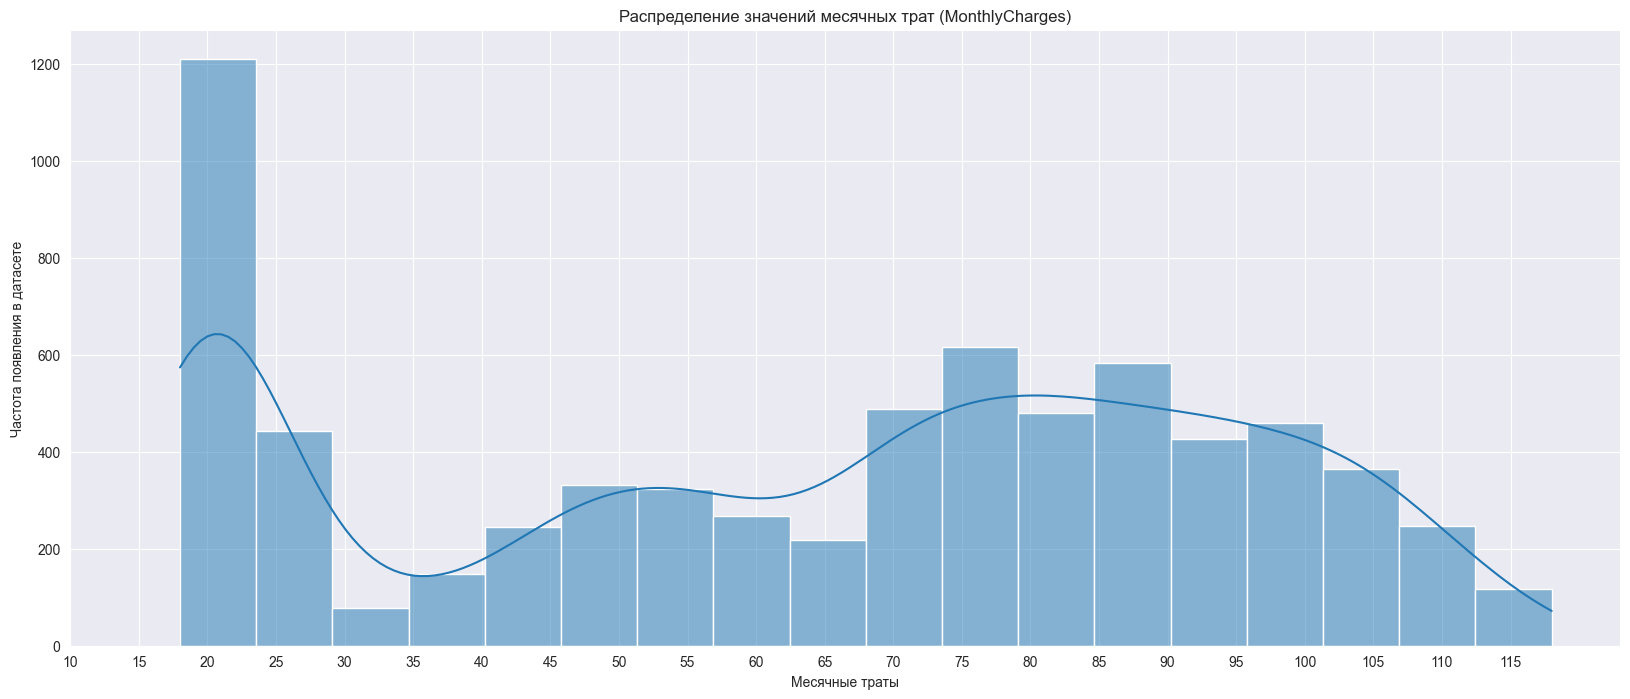

In [22]:
sns.histplot(df['MonthlyCharges'], kde=True)
plt.title('Распределение значений месячных трат (MonthlyCharges)')
plt.xlabel('Месячные траты')
plt.ylabel('Частота появления в датасете')
plt.xticks(np.arange(10, max(df['MonthlyCharges'])+2, 5))
#plt.yticks(np.arange(0, max(y), 2))
df['MonthlyCharges'].describe()

Есть 3 пика и 2 провала, первый пик это месчные траты  вразмере 20, их больше всего порялка 1200, на 30-35 достигается мимниму и потом ещн 2 пика в размере 50 и 80. Средние траты 64.

count    7043.000000
mean     2114.859009
std      2112.745015
min         0.000000
25%       436.500000
50%      1343.000000
75%      3236.000000
max      9221.000000
Name: TotalCharges, dtype: float64

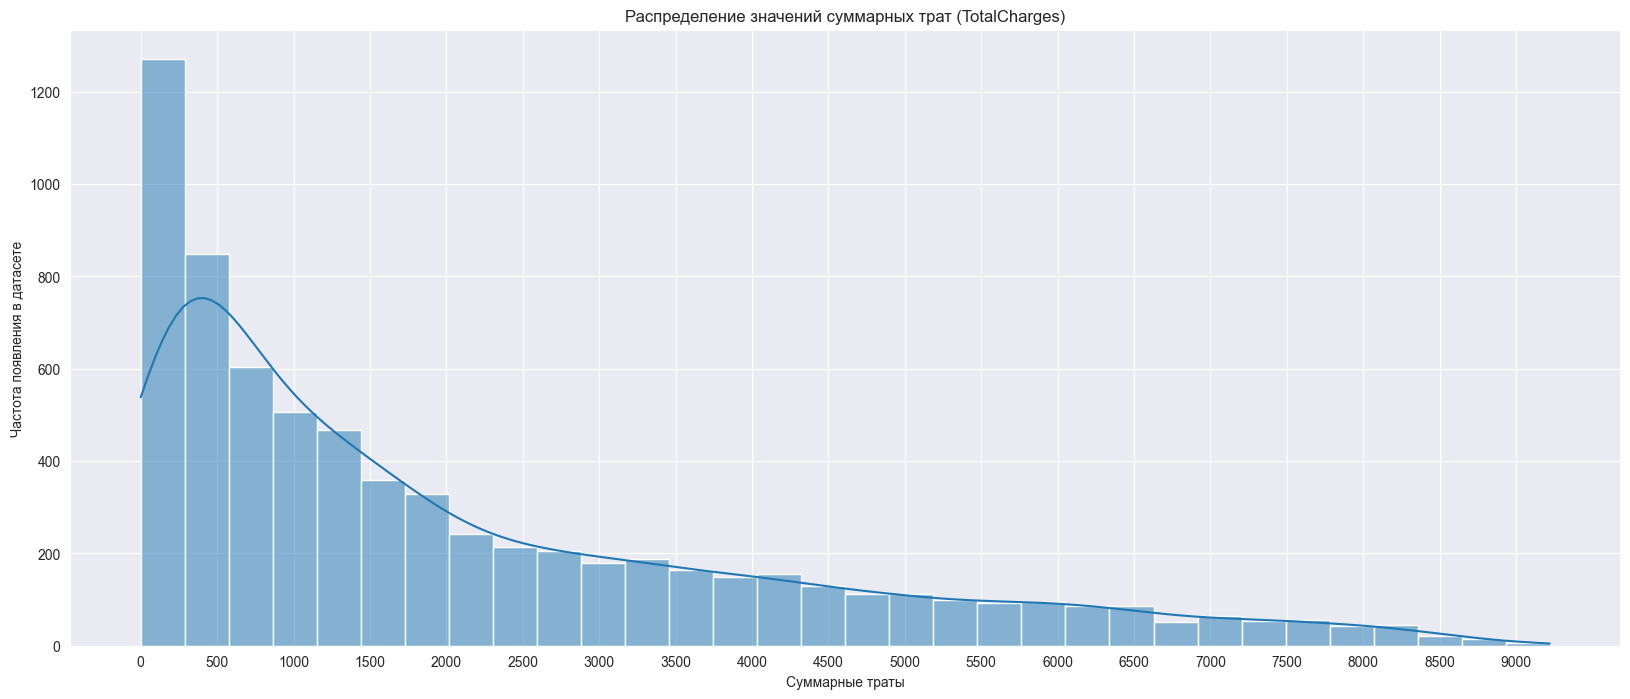

In [23]:
sns.histplot(df['TotalCharges'], kde=True)
plt.title('Распределение значений суммарных трат (TotalCharges)')
plt.xlabel('Суммарные траты')
plt.ylabel('Частота появления в датасете')
plt.xticks(np.arange(0, max(df['TotalCharges'])+2, 500))
#plt.yticks(np.arange(0, max(y), 2))
df['TotalCharges'].describe()

Больше всего клиентов которые которые почти ничего не потратили за год, потом график плавно падает. Это происходит потому что, как вяснилось ранее, много клиентов имеюют минимальный тариф. Средние расходы в год примерно 2100. 

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: days, dtype: float64

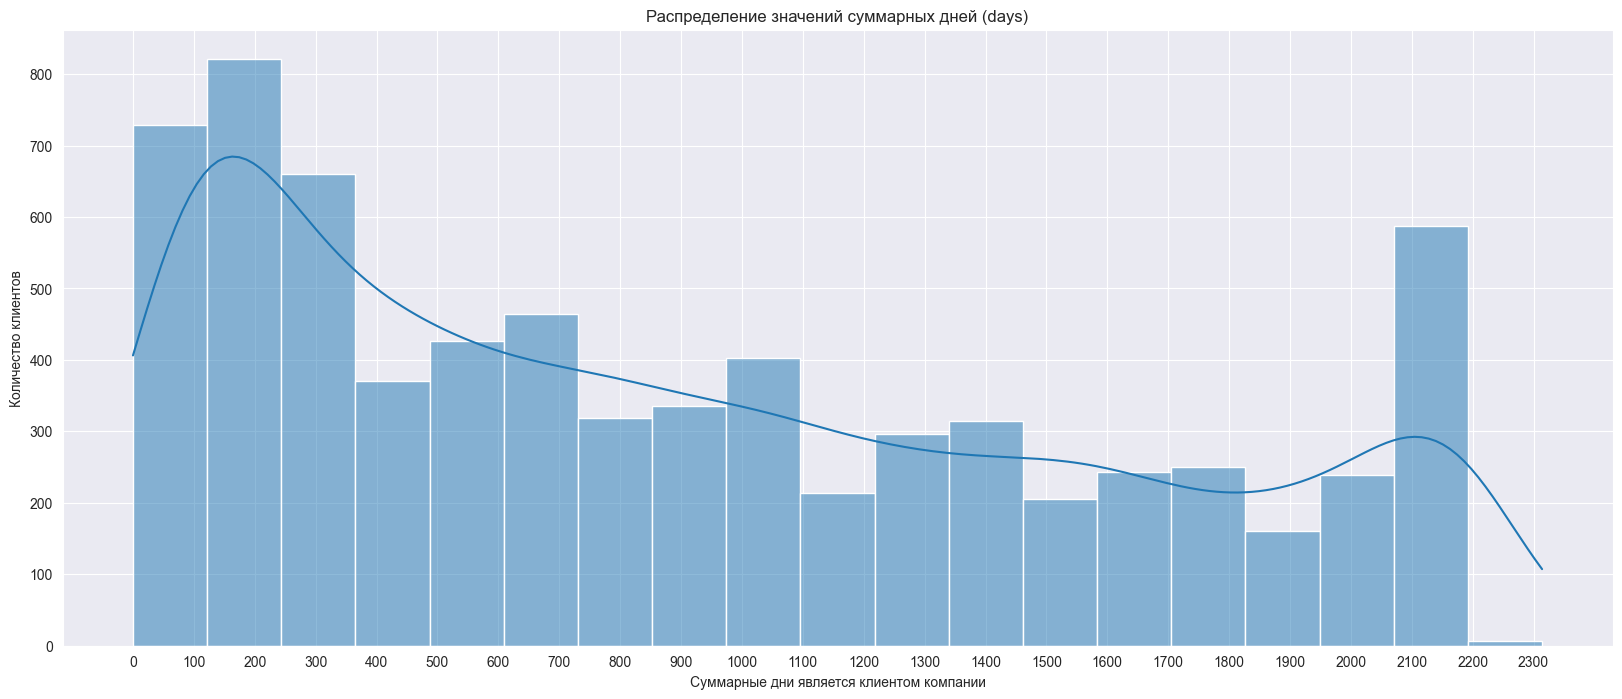

In [24]:
sns.histplot(df['days'], kde=True)
plt.title('Распределение значений суммарных дней (days)')
plt.xlabel('Суммарные дни является клиентом компании')
plt.ylabel('Количество клиентов')
plt.xticks(np.arange(0, max(df['days'])+2, 100))
#plt.yticks(np.arange(0, max(y), 2))
df['days'].describe()

Достаточно много новых клиентов кто с компанией менее года, пик 200, есть и немало "старожилов" , кто в компании более 5лет порядка 600. 

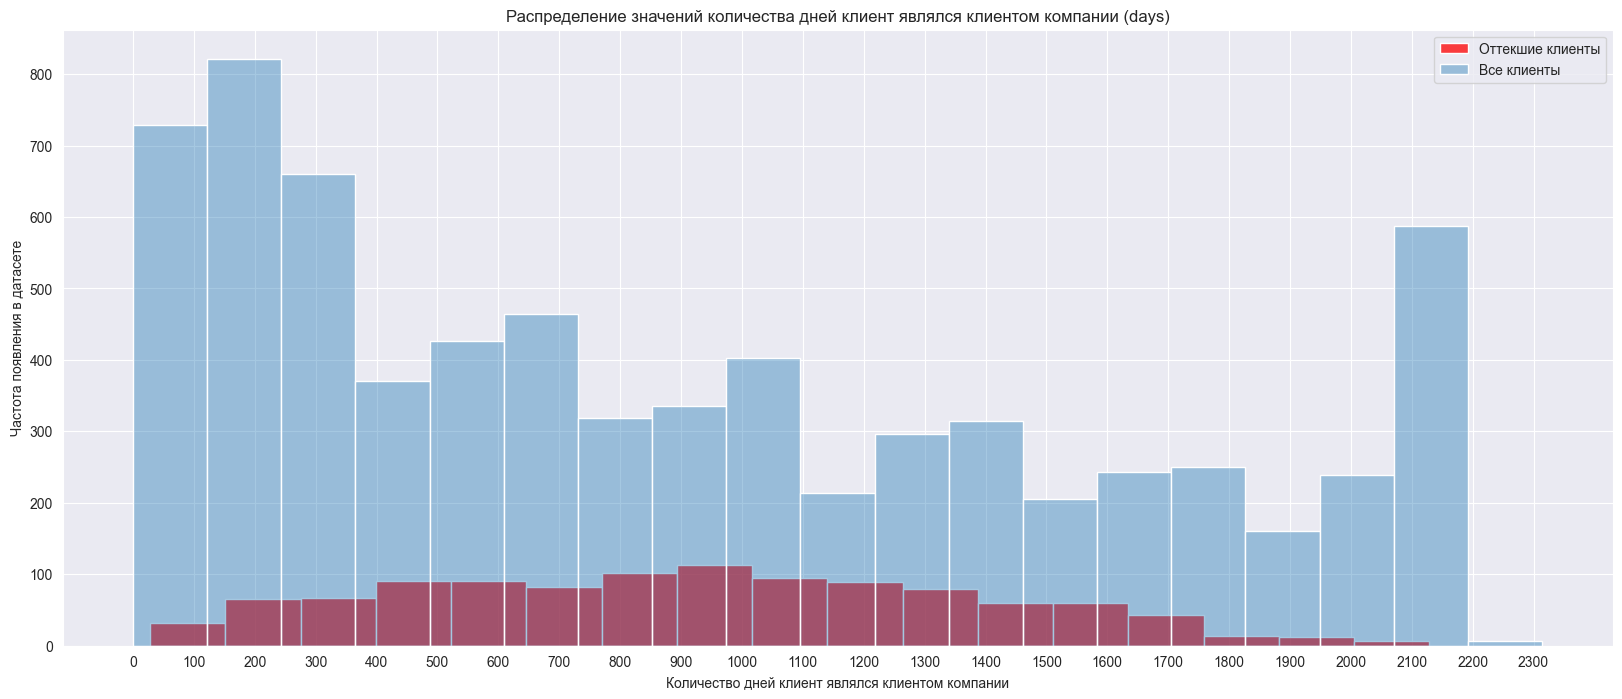

In [25]:
ax = sns.histplot(df.loc[df['resigned'] == 1,'days'], 
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df['days'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений количества дней клиент являлся клиентом компании (days)')
plt.xlabel('Количество дней клиент являлся клиентом компании')
plt.ylabel('Частота появления в датасете')
plt.xticks(np.arange(0, 2400, 100))
plt.show()

Большиство клиентов покидлает компанию спустя примерно 3 года, спустя 5 лет клиеты почти не покидают компанию, соотношение ушедшиз клиентов ко всем наименьшее в периоде в год. 

Изучим подробнее дату регистрации клиентов:

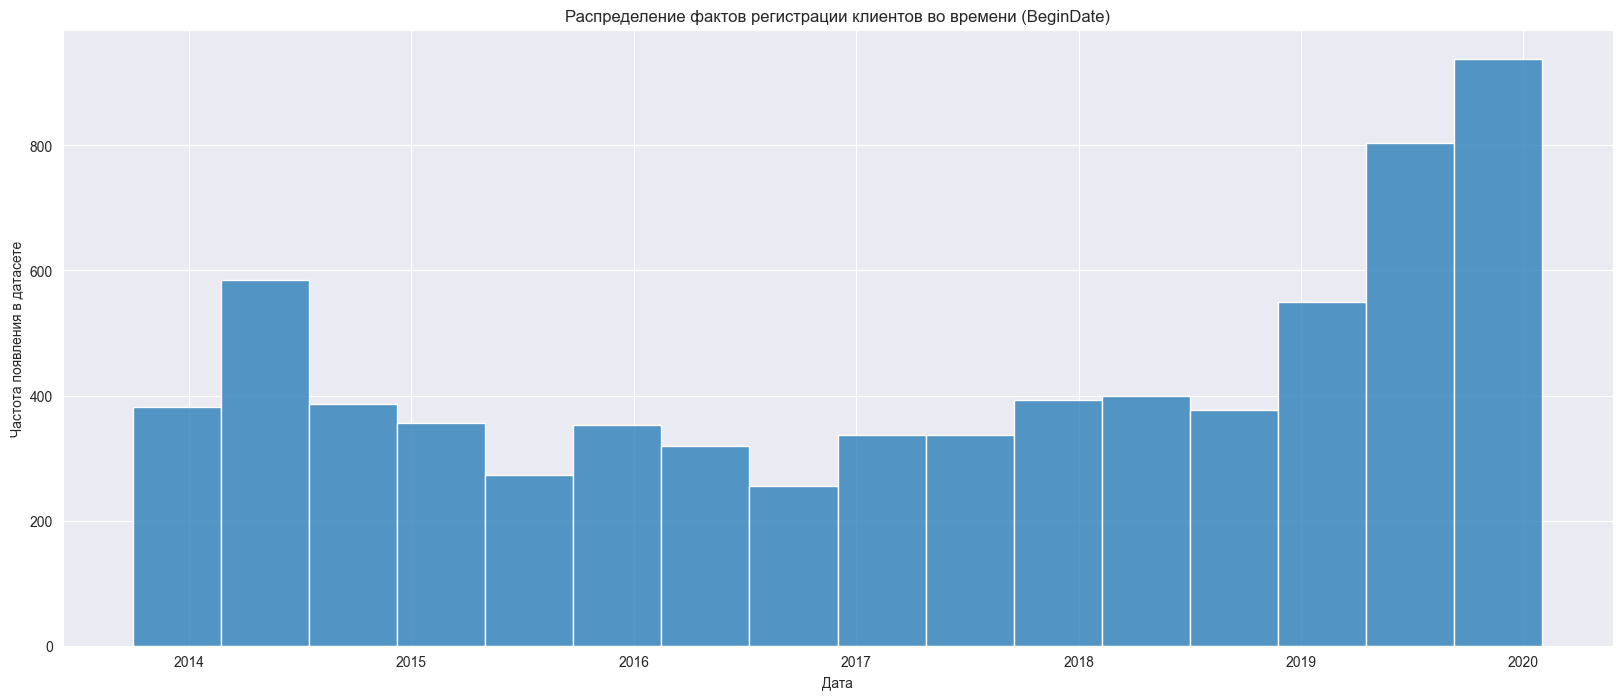

In [26]:
sns.histplot(df['BeginDate'])
plt.title('Распределение фактов регистрации клиентов во времени (BeginDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете')
plt.show()

Больше всего регистраций в 2020г. Так же видим старожилов, зарегистрировавшихся до 2015г.

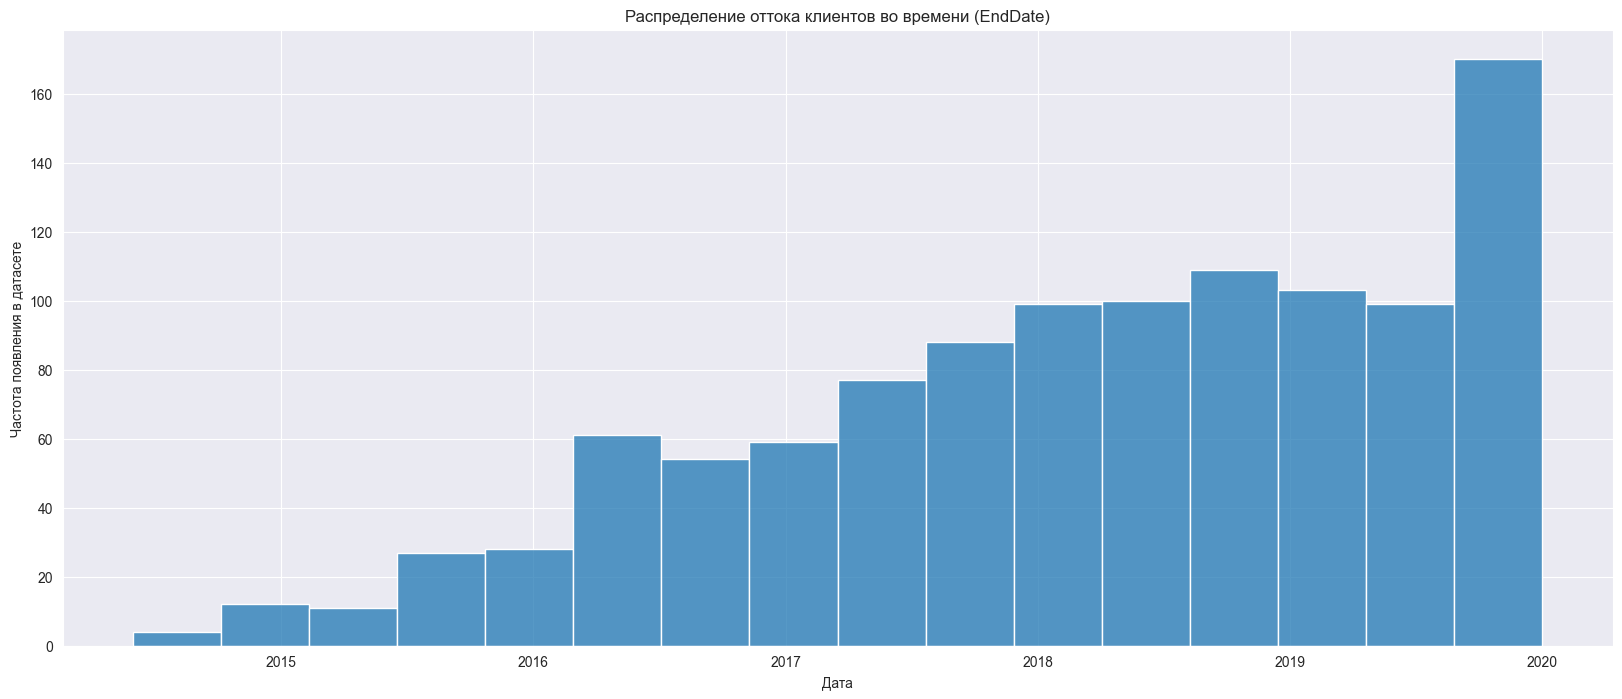

In [27]:
sns.histplot(df.query('EndDate != "2020-02-01"')['EndDate'])
plt.title('Распределение оттока клиентов во времени (EndDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете')
plt.show()

Наблюдается сильный оттко клиентов в текущем 2020г. при условии что прошло только 1,5 месяца спустя начала года. Понятно почему руководство переживает.

Посмотрим как распредлены месячные траты покинувших компанию и всех клиентов:

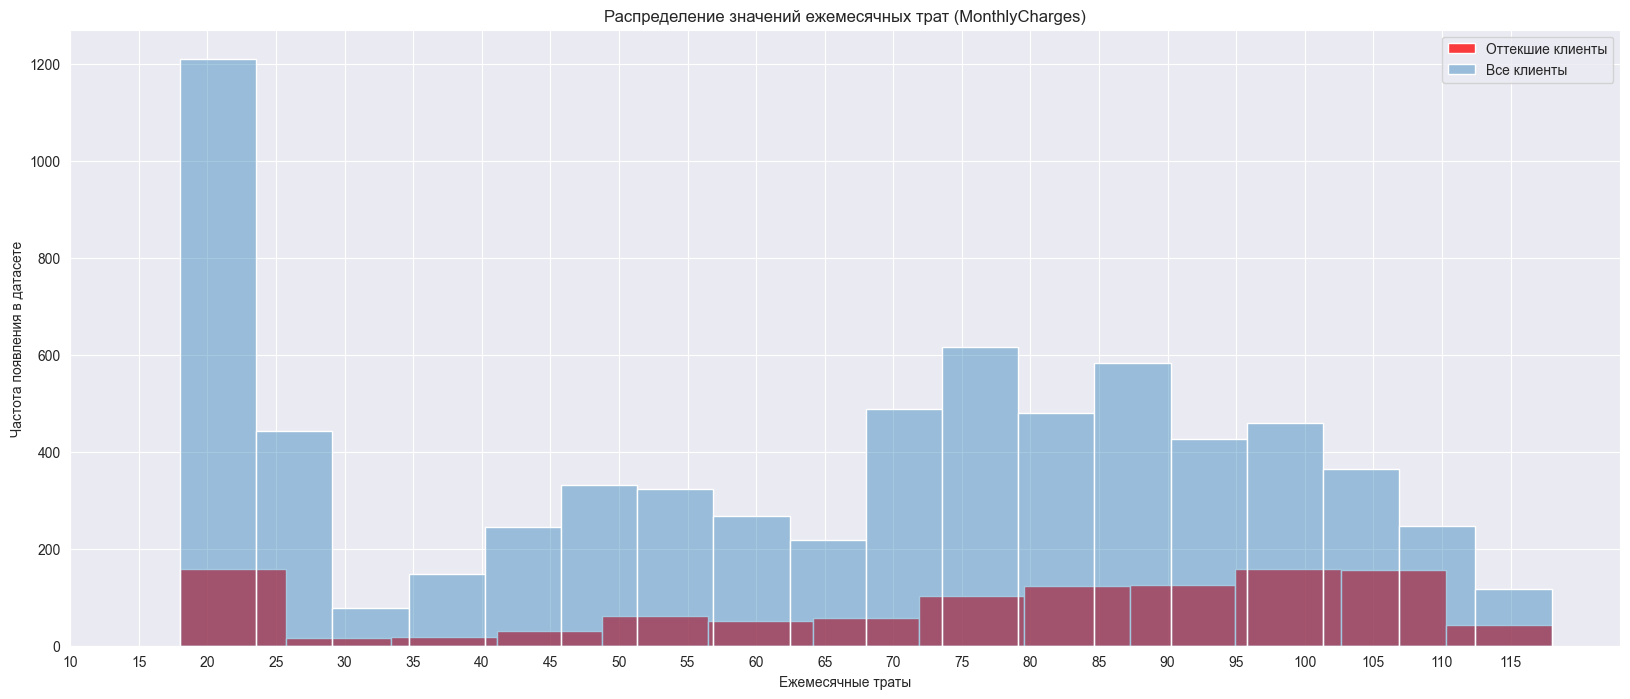

In [28]:
ax = sns.histplot(df.loc[df['resigned'] == 1,'MonthlyCharges'], 
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df['MonthlyCharges'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений ежемесячных трат (MonthlyCharges)')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Частота появления в датасете')
plt.xticks(np.arange(10, 120, 5))
plt.show()

Видно что покинувшие компанию клиенты пользовались дорогими тарифами. Больше всего пользователей минимального тарифа.

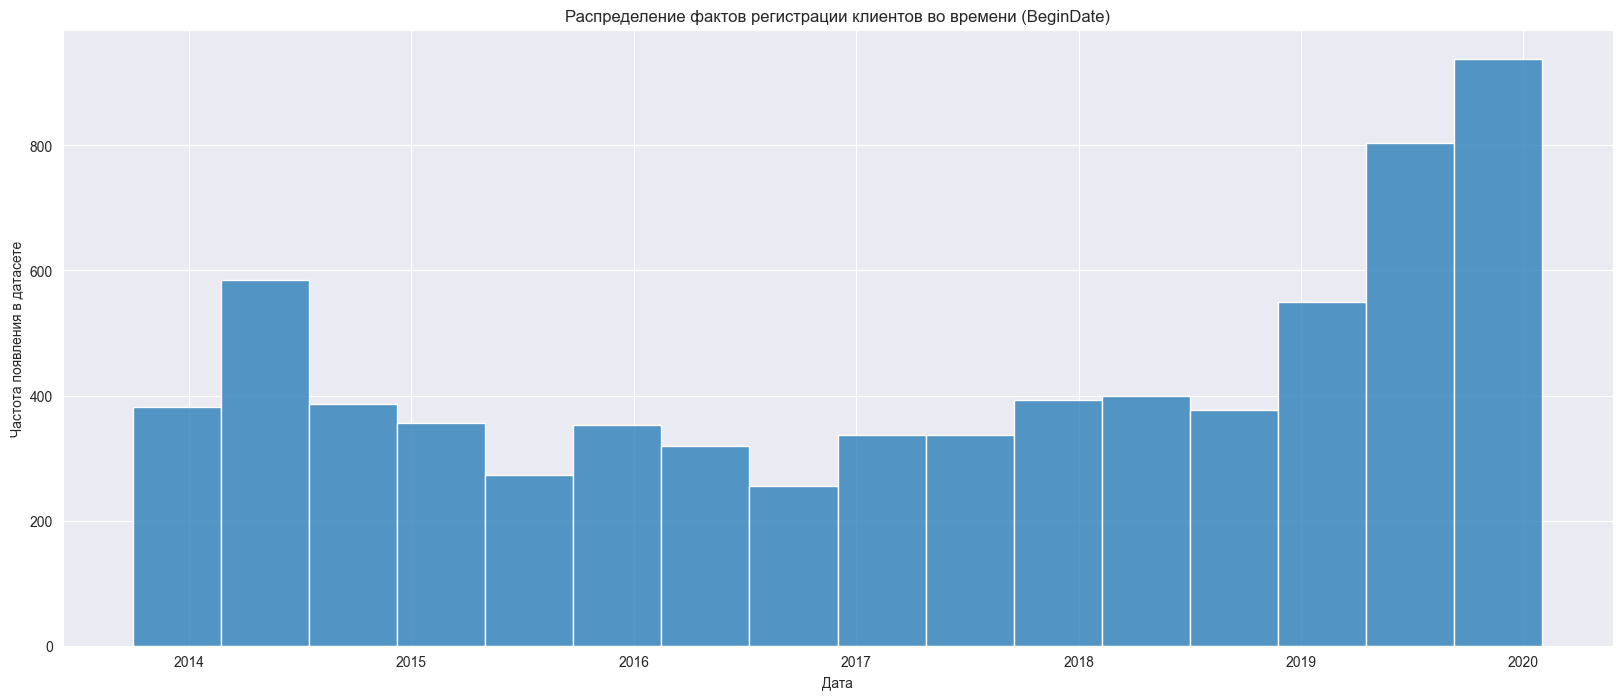

In [29]:
sns.histplot(df['BeginDate'])
plt.title('Распределение фактов регистрации клиентов во времени (BeginDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете')
plt.show()

Исследуем целевой признак `resigned`. 

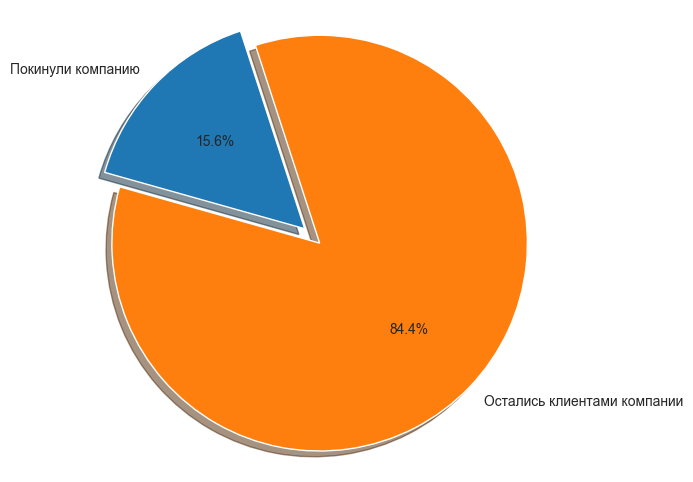

In [30]:
labels = 'Покинули компанию', 'Остались клиентами компании'
sizes = [df['resigned'][df['resigned'] == 1].count(), df['resigned'][df['resigned'] == 0].count()]
explode = (0.1, 0) 


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=108)
ax1.axis('equal') 

fig1.set_size_inches(6, 6)

plt.show()


Компаниюю за все время покинуло 16% клиентов.

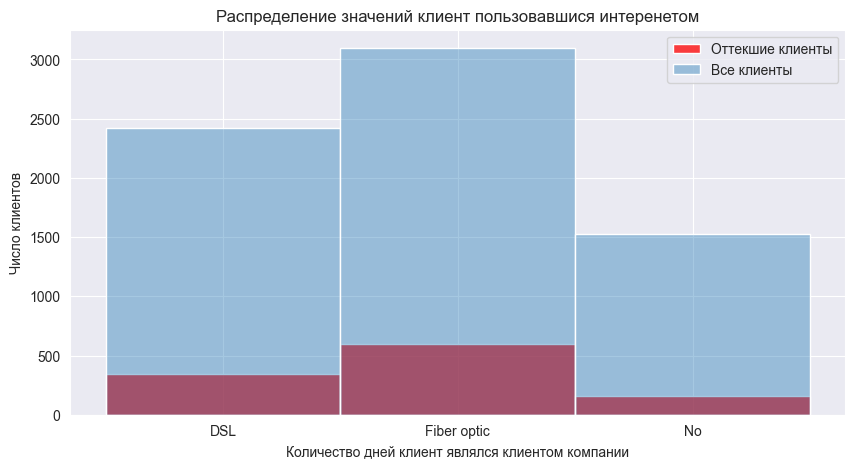

In [31]:
plt.rcParams["figure.figsize"] = (10,5)

ax = sns.histplot(df.loc[df['resigned'] == 1,'InternetService'], 
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df['InternetService'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений клиент пользовавшися интеренетом')
plt.xlabel('Количество дней клиент являлся клиентом компании')
plt.ylabel('Число клиентов')
#plt.xticks(np.arange(0, 2400, 100))
plt.show()

Соотновшение покинувших клиентов ко всем примерно равное для пользователей услуги интеренет.

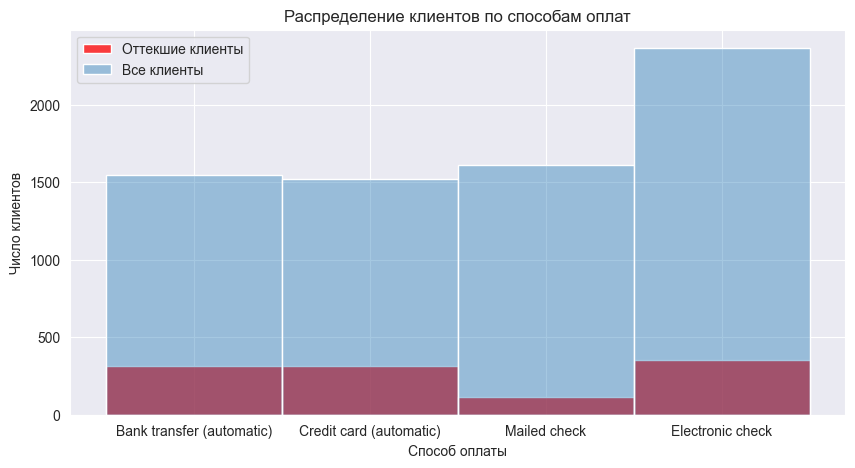

In [32]:
plt.rcParams["figure.figsize"] = (10,5)

ax = sns.histplot(df.loc[df['resigned'] == 1,'PaymentMethod'], 
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df['PaymentMethod'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение клиентов по способам оплат')
plt.xlabel('Способ оплаты')
plt.ylabel('Число клиентов')
#plt.xticks(np.arange(0, 2400, 100))
plt.show()

Наиболее лояльные клиенты те, что платят почтовыми чеками.

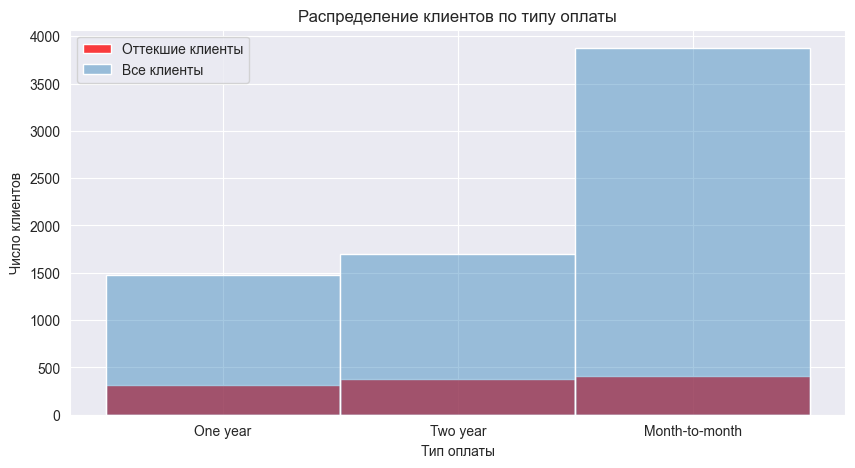

In [33]:
plt.rcParams["figure.figsize"] = (10,5)

ax = sns.histplot(df.loc[df['resigned'] == 1,'Type'], 
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df['Type'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение клиентов по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Число клиентов')
#plt.xticks(np.arange(0, 2400, 100))
plt.show()

Наименьшее соотношение клиентов, которые покидают, среди тех кто платит ежемесячно.

### Вывод

1. Исправили типы данных полей
2. Заменили 'Yes' и 'No', на 1 и 0 соотвественно, где возможно. Позже преобразуем методом OHE ряд полей для моделей логистической регрессии и случайного леса, а для LGBM переведем в категории в момент деления на выборки.
3. Ввели новую переменную - количество дней, которые клиент является/являлся клиентом компании.
4. Выделили целевой признак.
5. По данным выяснилось:
- Безналичный расчет использует 40% клиентов
- Несколько линий почти 60%
- Пенсионеров около 16%, женатых 51%, соотношение мужчин и женщин почти равное, много зависимых порядка 70% 
- Онлайн услугами пользуется боле 65%
6. Построив графики удалось выяснить следующее:
- Максимальное число пользователей имеют низкие месячные траты  в размере 20. Видно что покинувшие компанию клиенты пользовались дорогими тарифами. Больше всего пользователей имеют минимальный тариф.
- В компании достаточно много новых клиентов, кто с компанией менее года, есть и немало "старожилов" , кто в компании более 5 лет - порядка 600. 
- Большиство клиентов покидлает компанию спустя примерно 3 года, спустя 5 лет клиеты почти не покидают компанию, соотношение ушедшиз клиентов ко всем наименьшее в периоде в год. 
- Больше всего регистраций в 2020г. Так же видим старожилов, зарегистрировавшихся до 2015г.
- Наблюдается сильный отток клиентов в текущем 2020г. при условии что прошло только 1,5 месяца спустя начала года. Понятно почему руководство переживает.
- Компаниюю за все время покинуло 16% клиентов.
- Соотновшение покинувших клиентов ко всем примерно равное для пользователей услуги интеренет.
- Наиболее лояльные клиенты те, что платят почтовыми чеками.
- Наименьшее соотношение клиентов, которые покидают, среди тех кто платит ежемесячно.


## Подготовка данных для модели

### Корреляция признаков

Изучим корреляцию признаков.

In [34]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'days']

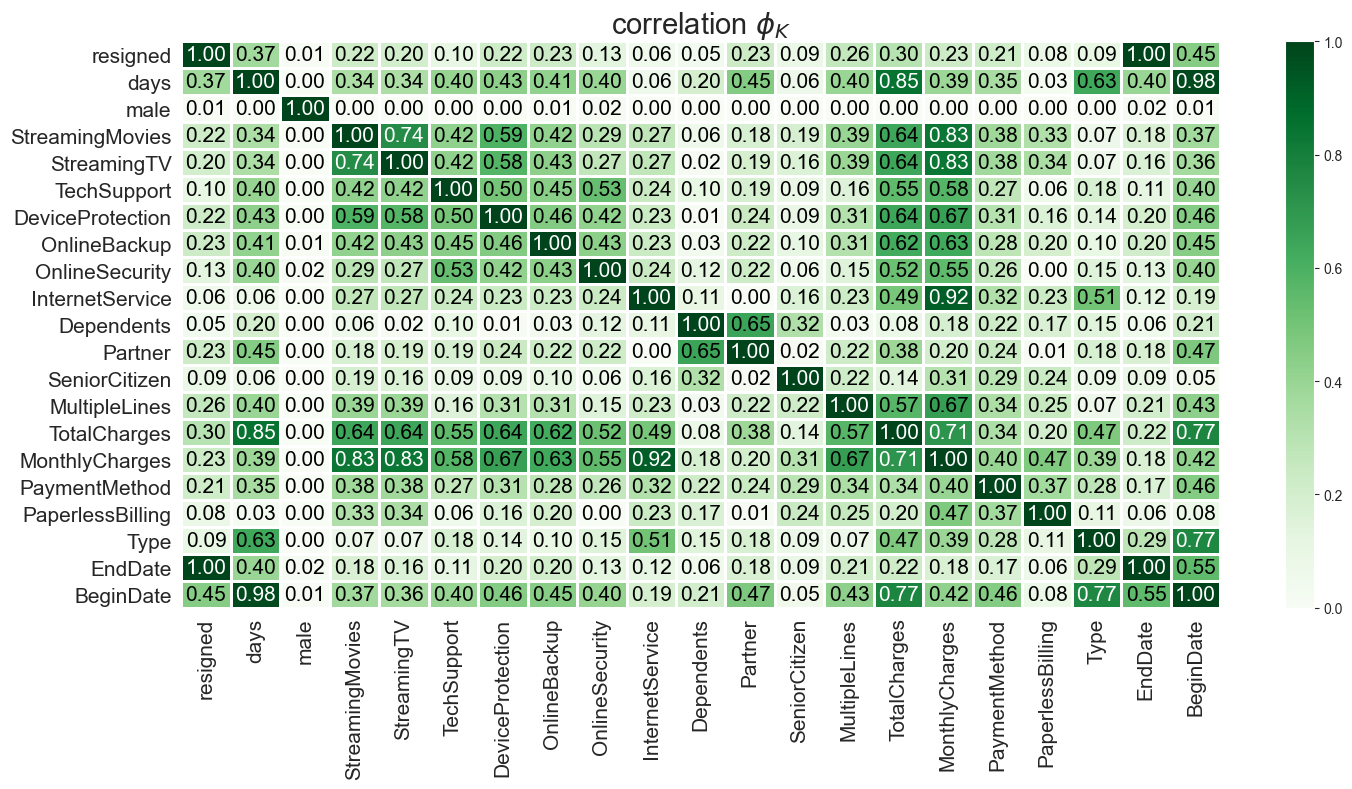

In [35]:

phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

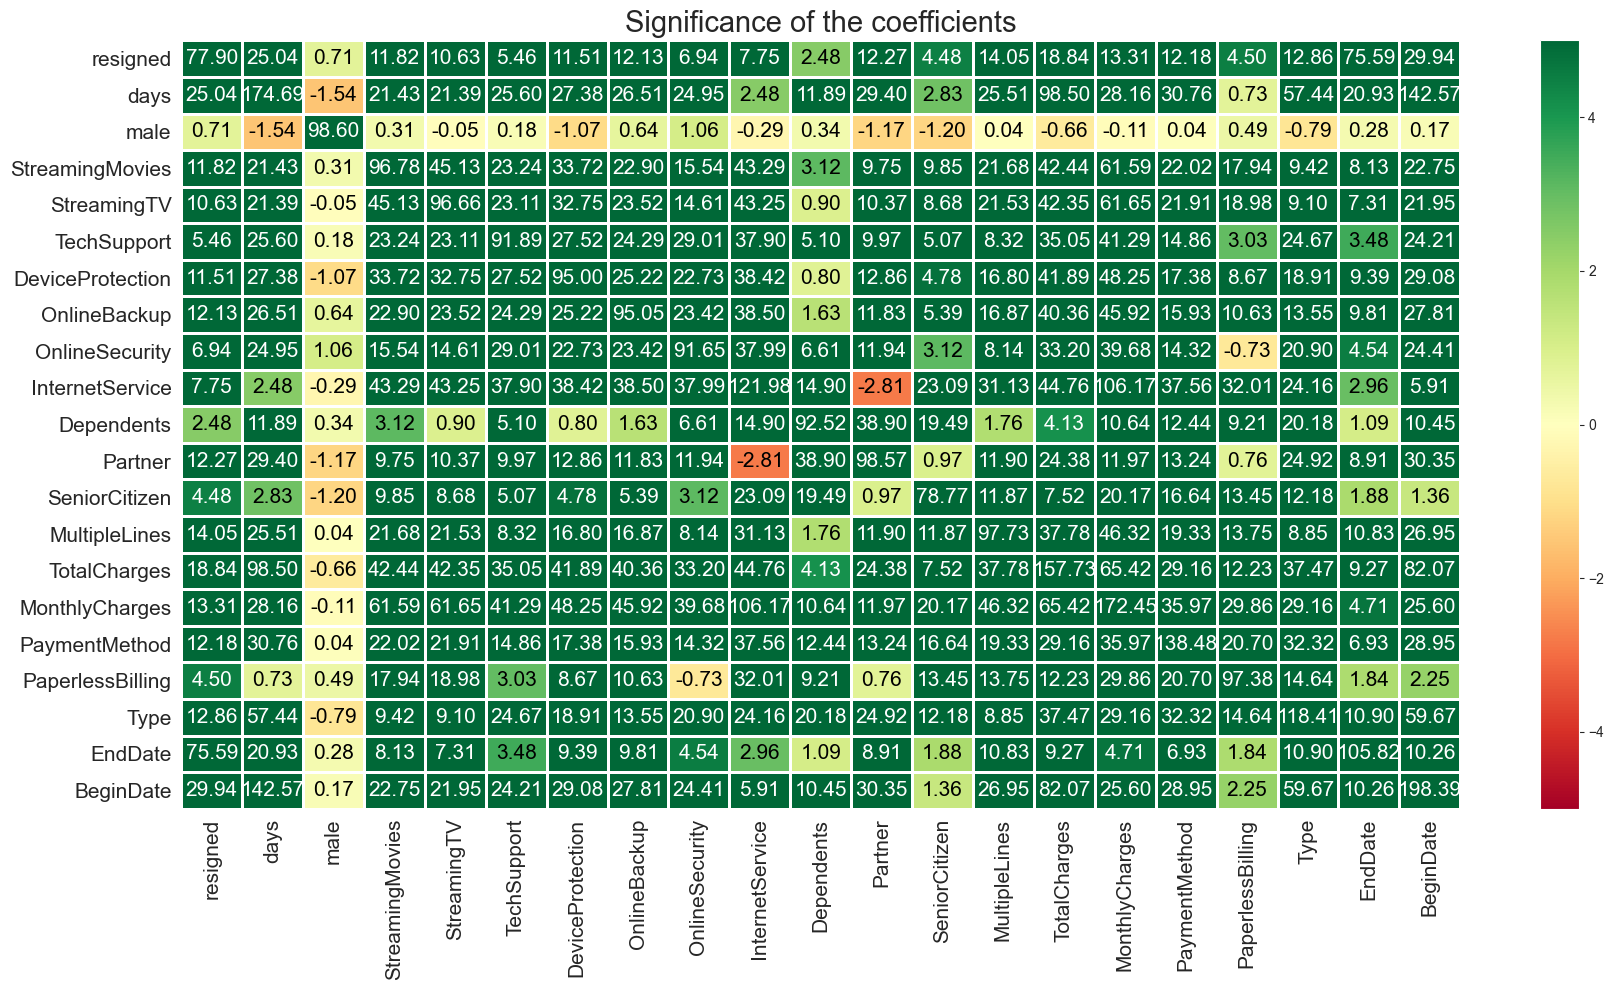

In [36]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 10))
plt.tight_layout()

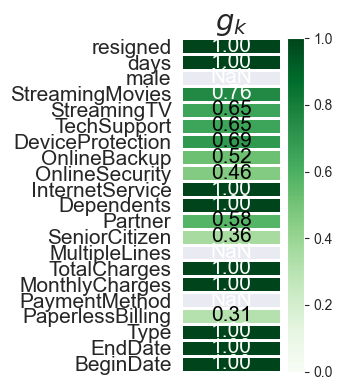

In [37]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Исходя из 3х таблиц видно что есть сильная корреляция между `resigned` и `EndDate`, также  `BeginDate` и `days`, `MonthlyCharges` и `TotalCharges`, `MonthlyCharges` и `InternetService`, а `male` мало значим. Так как у нас есть обобщающий показатель `days`, отбросим  `EndDate`, `BeginDate`, `TotalCharges` отбросим потому что есть `MonthlyCharges`, которая не имеет накопительного эффекта, `InternetService` потому что это обобщающий показатель (если пользователь является пользователем интернета, у него точно есть одна из услуг из этого списка),  `male` потому что он мало значим.

### Преобразование и маштабирование признаков

Прежде чем обучить модели преобразуем категориальные признаки в численные с помощью техники Прямого кодирования (One-Hot Encoding).

In [38]:
categories_all = ['PaymentMethod','Type', 'InternetService']

#df_ohe = df.copy()

#df_ohe = pd.get_dummies(data=df, columns=categories_all, drop_first=True)

#df_ohe.head()

categories_all

['PaymentMethod', 'Type', 'InternetService']

Разделим датасет на выборки (тренировочной к тестовой должно быть 3/1).

In [39]:
target = df['resigned']

#features = df.drop(['resigned', 'EndDate', 'BeginDate', 'TotalCharges', 'InternetService', 'male'], axis=1)

features = df.drop(['resigned', 'EndDate', 'BeginDate', 'TotalCharges', 'male'], axis=1) #вернул 'InternetService'

#features_train, features_temp, target_train, target_temp = train_test_split(
#    features, target, test_size=0.40, random_state=RANDOM_STATE)

#features_valid, features_test, target_valid, target_test = train_test_split(
#    features_temp, target_temp, test_size=0.50, random_state=RANDOM_STATE)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)



#проверим размеры
print(features_train.shape)
print(target_train.shape)
#print(features_valid.shape)
#print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)


(5282, 16)
(5282,)
(1761, 16)
(1761,)


Данные разделены в верной пропорции.

Смаштабируем числовые признаки.

In [40]:
numeric = ['MonthlyCharges','days']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) #обучаем на тренировочной
features_train[numeric] = scaler.transform(features_train[numeric])
#features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())

#display(features_valid.head())

display(features_test.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,MultipleLines,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days
customerID,,,,,,,,,,,,,,,,
2205-LPVGL,One year,0,Bank transfer (automatic),0.819875,0,1,0,0,Fiber optic,0,0,1,0,1,1,1.251417
5940-NFXKV,Month-to-month,0,Electronic check,0.620543,0,0,0,0,Fiber optic,1,1,1,1,1,0,-1.197416
5453-YBTWV,Two year,0,Credit card (automatic),1.218539,1,0,0,0,Fiber optic,0,0,0,0,0,1,1.785043
1325-USMEC,Two year,0,Credit card (automatic),1.152095,0,0,0,1,Fiber optic,0,0,0,1,0,1,1.785043
3199-NPKCN,One year,0,Electronic check,1.550758,0,0,0,1,Fiber optic,0,1,0,0,0,0,1.652002


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,MultipleLines,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days
customerID,,,,,,,,,,,,,,,,
6728-VOIFY,One year,0,Electronic check,1.052429,1,0,0,1,Fiber optic,1,0,1,1,0,0,1.472177
4942-VZZOM,One year,0,Credit card (automatic),0.055770,0,0,0,1,DSL,0,1,1,1,0,1,1.517499
4760-THGOT,Month-to-month,0,Electronic check,0.985985,0,0,0,1,Fiber optic,0,0,1,1,1,0,0.583287
7067-KSAZT,One year,0,Electronic check,1.384648,0,1,0,1,Fiber optic,1,0,0,1,0,0,1.606680
6874-SGLHU,One year,0,Bank transfer (automatic),1.085651,1,0,1,1,Fiber optic,1,0,1,1,0,0,0.004339


In [41]:
features_train_ohe = features_train.copy()
#features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

In [42]:
ohe_features = ['PaymentMethod','Type', 'InternetService']

encoder_ohe = OneHotEncoder(drop='first', sparse=False)

encoder_ohe.fit(features_train_ohe[ohe_features])


features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[ohe_features])

#features_valid_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohe[ohe_features])

features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[ohe_features])

features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

#features_valid_ohe = features_valid_ohe.drop(ohe_features, axis=1)

features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)


# смотрим на результат

display(features_train_ohe.head())

#display(features_valid_ohe.head())

display(features_test_ohe.head())

,PaperlessBilling,MonthlyCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No
customerID,,,,,,,,,,,,,,,,,,,,
2205-LPVGL,0,0.819875,0,1,0,0,0,0,1,0,1,1,1.251417,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5940-NFXKV,0,0.620543,0,0,0,0,1,1,1,1,1,0,-1.197416,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5453-YBTWV,0,1.218539,1,0,0,0,0,0,0,0,0,1,1.785043,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1325-USMEC,0,1.152095,0,0,0,1,0,0,0,1,0,1,1.785043,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3199-NPKCN,0,1.550758,0,0,0,1,0,1,0,0,0,0,1.652002,0.0,1.0,0.0,1.0,0.0,1.0,0.0


,PaperlessBilling,MonthlyCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No
customerID,,,,,,,,,,,,,,,,,,,,
6728-VOIFY,0,1.052429,1,0,0,1,1,0,1,1,0,0,1.472177,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4942-VZZOM,0,0.055770,0,0,0,1,0,1,1,1,0,1,1.517499,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4760-THGOT,0,0.985985,0,0,0,1,0,0,1,1,1,0,0.583287,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7067-KSAZT,0,1.384648,0,1,0,1,1,0,0,1,0,0,1.606680,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6874-SGLHU,0,1.085651,1,0,1,1,1,0,1,1,0,0,0.004339,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Данные успешно закодированы.

Подготим категориальные признаки для LGBMClassifier.

In [43]:
categories_all = ['PaymentMethod','Type', 'InternetService']

#df_cat = df.copy()

for category in categories_all:
    features_train[category] = features_train[category].astype('category')
    #features_valid[category] = features_valid[category].astype('category')
    features_test[category] = features_test[category].astype('category')
    #features[category] = features[category].astype('category')
    
features_train[categories_all].info()
#features_valid[categories_all].info()
features_test[categories_all].info()
#features[categories_all].info()


<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2205-LPVGL to 5375-XLDOF
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PaymentMethod    5282 non-null   category
 1   Type             5282 non-null   category
 2   InternetService  5282 non-null   category
dtypes: category(3)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 6728-VOIFY to 5175-WLYXL
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PaymentMethod    1761 non-null   category
 1   Type             1761 non-null   category
 2   InternetService  1761 non-null   category
dtypes: category(3)
memory usage: 19.4+ KB


### Обучение моделей

Подготовим функцию для обучения моделей, получения времени обучения/предсказания и метрик AUC-ROC и F1.

In [44]:
def train (model,features, target, title):
    start1 = time.time()
    model.fit(features, target)
    finish1 = time.time() - start1 #время обучения модели
    

    accuracy_all = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    accuracy_cross_val = accuracy_all.mean()

    roc_auc_all = cross_val_score(model, features, target, cv=5, scoring='roc_auc')
    roc_auc_cross_val = roc_auc_all.mean()

    result = [finish1, accuracy_cross_val, roc_auc_cross_val]
    
    print (f'\nРеультат работы модели {title}')                                                                          # время предсказания AUC-ROC и accuracy по валидационной выборке  
    print ('\nВремя обучения модели,сек.:',result[0])
    print ('\nРазмер метрики accuracy на кросс-валидации:',result[1])
    print ('\nРазмер метрики AUC-ROC на кросс-валидации:',result[2])
    return result;

#### Логистическая регрессия

In [45]:
LR_info = train(LogisticRegression(),
                        features_train_ohe, target_train,
                        'LogisticRegression')


Реультат работы модели LogisticRegression

Время обучения модели,сек.: 0.3001899719238281

Размер метрики accuracy на кросс-валидации: 0.857818547346693

Размер метрики AUC-ROC на кросс-валидации: 0.7475181036784285


#### Случайный лес

Подберем параметры.

In [46]:
rfc_random_grid = {'n_estimators': [10, 50, 200, 1000, 2000],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [10, 20, 50, 100, None],
               'min_samples_split': [1, 2, 4],
               'min_samples_leaf': [2, 5, 10],
               'bootstrap': [True, False]}
rfc_random_grid


{'n_estimators': [10, 50, 200, 1000, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 50, 100, None],
 'min_samples_split': [1, 2, 4],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False]}

Найдем наилучшие гиперпараметры.

In [47]:
%%time
rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = rfc_random_grid, n_iter = 100, cv = 3, verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
rfc_random.fit(features_train_ohe, target_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=1, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=1, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, min_samples_split=1, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=1, n_estimators=

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 50, 100, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [1, 2, 4],
                                        'n_estimators': [10, 50, 200, 1000,
                                                         2000]},
                   random_state=220523, verbose=2)

In [48]:
print('Лучшие гиперпараметры модели Random Forest Classifier:')
rfc_random.best_params_

Лучшие гиперпараметры модели Random Forest Classifier:


{'n_estimators': 2000,
 'min_samples_split': 1,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

Обучим модель с найденными гиперпараметрами.

In [49]:
RFС_info = train(RandomForestClassifier(random_state=RANDOM_STATE, **rfc_random.best_params_),
                    features_train_ohe, target_train,
                    'RandomForestClassifier')


Реультат работы модели RandomForestClassifier

Время обучения модели,сек.: 4.900933027267456

Размер метрики accuracy на кросс-валидации: 0.8585788108139102

Размер метрики AUC-ROC на кросс-валидации: 0.8111499742099608


#### LGBMClassifier

Найдем наилучшие гиперпараметры.

In [50]:
lgbmc_random_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'min_child_samples': [1, 5, 10]
}


estimator = lgb.LGBMClassifier(objective='binary', 
                              random_state=RANDOM_STATE)

lgbmc_grid = GridSearchCV(estimator=estimator, 
                     param_grid=lgbmc_random_grid,
                     cv=3, 
                     n_jobs=-1, 
                     scoring='roc_auc', verbose= -1)
lgbmc_grid.fit(features_train_ohe, target_train)

print('Лучшие гиперпараметры модели LGBM:')
lgbmc_grid.best_params_

Лучшие гиперпараметры модели LGBM:


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_samples': 1,
 'n_estimators': 150,
 'subsample': 0.6}

Обучим модель с найденными гиперпараметрами.

In [51]:
LGBMC_info = train(lgb.LGBMClassifier(objective='binary', random_state=RANDOM_STATE,**lgbmc_grid.best_params_),
                        features_train, target_train, 'LGBMClassifier')


Реультат работы модели LGBMClassifier

Время обучения модели,сек.: 0.509364128112793

Размер метрики accuracy на кросс-валидации: 0.8941699994266219

Размер метрики AUC-ROC на кросс-валидации: 0.8855330565452639


Отличные показатели показала модель LGBMClassifier.


## Сравнение моделей


Изучим таблицу с показателями всех моделей.

In [52]:
models_summary = pd.DataFrame([LR_info, RFС_info, LGBMC_info], 
             columns=['Время обучения', 'Accuracy на кросс-валидации', 'AUC-ROC на кросвалидации'], 
             index=['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'])


models_summary.sort_values(by='AUC-ROC на кросвалидации', ascending=False)

,Время обучения,Accuracy на кросс-валидации,AUC-ROC на кросвалидации
LGBMClassifier,0.509364,0.894170,0.885533
RandomForestClassifier,4.900933,0.858579,0.811150
LogisticRegression,0.300190,0.857819,0.747518


LGBMClassifier показала себя наилучшим образом, лишь она смогла превысит требуемый показатель AUC-ROC в размере 0.85 на кросс-валидации, Accuracy на кросс-валидации 0.89.

Проверим LGBMClassifier на тестовой выборке.

## Тестирование лучшей модели

In [53]:
lgbmc_model = lgb.LGBMClassifier(objective='binary', random_state=RANDOM_STATE, **lgbmc_grid.best_params_).fit(features_train, target_train)

predict = lgbmc_model.predict(features_test)

probabilities_test = lgbmc_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc_model_lgbmc_test = roc_auc_score(target_test, probabilities_one_test)

print('AUC-ROC на тестовой выборке:', auc_roc_model_lgbmc_test)


AUC-ROC на тестовой выборке: 0.9192484962112334


Отлично! Модель LGBMClassifier на тестовой выборке показала себя не хуже чем на кросс-валидации. Задача выполнена.

Изучим тепловую карту и ROC-кривую.

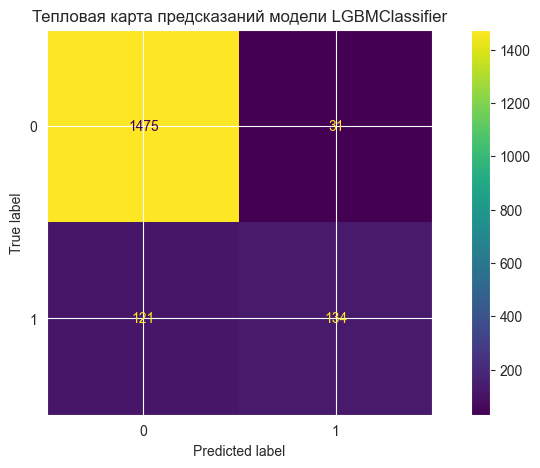

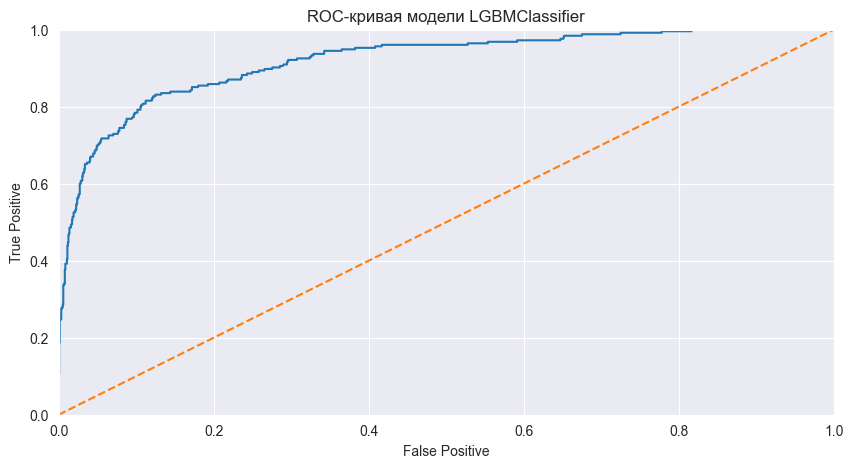

In [54]:
predictions_test = lgbmc_model.predict(features_test)

cm = confusion_matrix(target_test, predictions_test, labels=lgbmc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbmc_model.classes_)
disp.plot()

plt.title('Тепловая карта предсказаний модели LGBMClassifier')
plt.show()

probabilities_test = lgbmc_model.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive')
plt.ylabel('True Positive')

plt.title('ROC-кривая модели LGBMClassifier')
plt.show()

Отличные показатели показала модель LGBMClassifier.

Изучим значимость признаков.

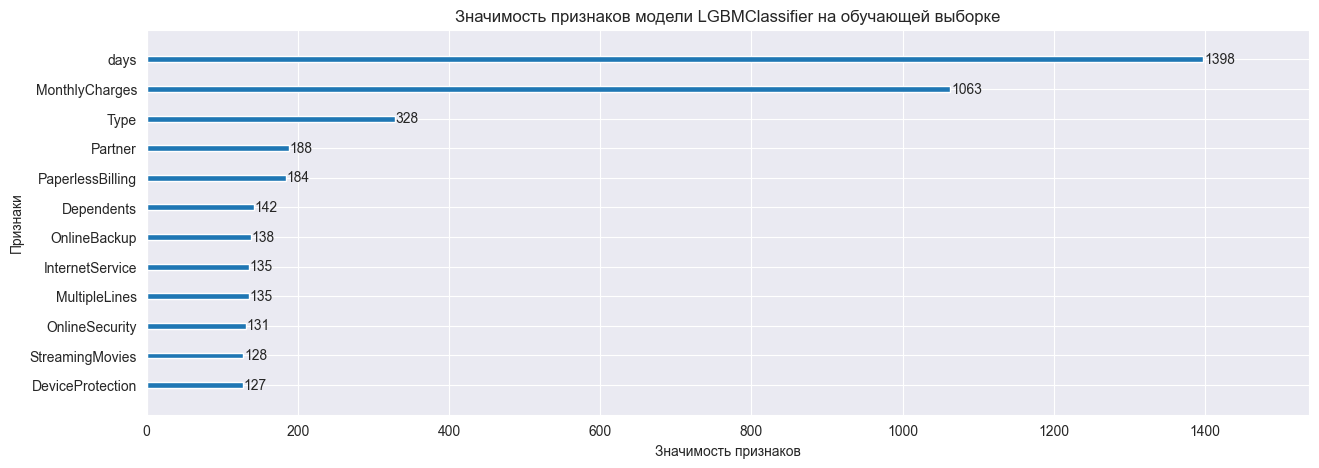

In [55]:
lgb.plot_importance(lgbmc_model, figsize=(15,5),max_num_features=12)
plt.title('Значимость признаков модели LGBMClassifier на обучающей выборке')
plt.xlabel('Значимость признаков')
plt.ylabel('Признаки')
plt.show()

Наиболее значими признаком показал себя показатель `days` - чем больше времени клиент провел в компании, тем вероятнее он ее покинет ее, также высокую значимость показывает признак `MonthlyCharges`, то есть чем клиент больше платит ежемесячно, тем вероятнее что он ее покинет компанию. 

## Вывод

Во время проведения работы было сделано:
1. Загрузка и предварительный анализ данных. Пропусков не было найдено, но были обнаружены и заменены неявные пропуски, ряду полей изменен тип данных. Заменили большинство полей на бинарный тип данных. Объединили все данные в единую таблицу.
2. Проведена предобработку и исследовательский анализ данных. Выделен целевой признак и ряд закономерностей.
3. Изучена корреляция признаков, часть из которых были удалены из числа признаков. Подготовлены данные для модели - для ряда моделей данные закодированы методом прямого кодирования, для других переведены в тип данных 'категория', проведено маштабирование числовых признаков. 
4. Итоговая таблица разделена на обучающую и тестовую выборки в пропорции 3/1. 
5. Проведено обучение моделей. Изучили значимость признаков, самыми значими являются: число дней клиент является клиентом компании `days` и месячные затраты `MonthlyCharges`.
6. Проведено сравнение моделей, лучшей стала LGBMClassifier с AUC-ROC выше 0.85 на кросс-валидации, Accuracy на кросс-валидации 0.89, показатель AUC-ROC на тестовой выборке сильно не изменились. 